> ### EEE4423: Deep Learning Lab

# LAB \#10: Image Style Transfer

In [ ]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-05-08 01:12:26.628993




# Neural Stylization with Pytorch
## Introduction


<img src="http://drive.google.com/uc?export=view&id=1crqAv5aoJ3uMSDFT99l6VuzY3VUlF_C7" alt="no_image" style="width: 900px;"/>

This lab introduces a Neural Algorithm of Artistic Style that can separate and recombine the image content and style of natural images. The algorithm takes two images, a content-image, and a style-image, and generates the optimized image to resemble the content of the content-image and the artistic style of the style-image.


**Main idea**

To transfer the style image $\textit{I}_s$ onto a content image $\textit{I}_c$ we synthesize a new image that simultaneously matches the content representation of $\textit{I}_c$ and the style representation of $\textit{I}_s$ (Fig). Thus we jointly minimize the distance of the feature representations of a white noise image from the content representation of the photograph in one layer and the style representation of the painting defined on a number of layers of the Convolutional Neural Network.
<img src="http://drive.google.com/uc?export=view&id=1BhfqqQEMn3AyHpc6fB-shQDlU-tQeoLz" alt="no_image" style="width: 900px;"/>

In [ ]:
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import numpy as np

from torchvision import datasets
from torch.utils.data import DataLoader

warnings.filterwarnings("ignore")

**Style and content image**

In [ ]:
style_img_name = '../dataset/lab10/style/mosaic.jpg'
content_img_name = '../dataset/lab10/content/Tuebingen_Neckarfront.jpg'

In [ ]:
style_img = Image.open(style_img_name)
content_img = Image.open(content_img_name)

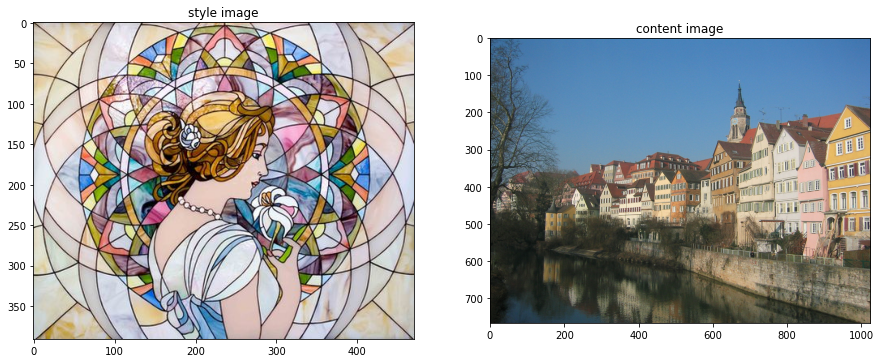

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,2,2)
plt.title('content image')
plt.imshow(content_img)

### Style representation

To obtain a representation of the style of an input image, we use a feature space designed to capture texture information. This feature space can be built on top of the filter responses in any layer of the network. It consists of the correlations between the different filter responses, where the expectation is taken over the spatial extent of the feature maps. These feature correlations are given by the Gram matrix $\mathit{G} \in \mathcal{R}^{\mathit{N_l}  \times  \mathit{N_l}}$, where $\mathit{G^l_{ij}}$ is the inner product between the vectorised feature maps $i$ and $j$ in layer $l$:

### <center> ${\mathit{G^l_{ij}} = \sum_{k}{F^l_{ik}F^l_{jk}}}$ </center>

In [ ]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

### Deep image representations

In this work we show how the generic feature representations learned by high-performing Convolutional Neural Networks can be used to independently process and manipulate the content and the style of natural images.

The image reperesentations were generated on the basis of the VGG network, which was trained to perform object recognition and localization. We use the feature space provided by the 16 convolutional and 5 pooling layers of the 19-layer VGG network.

In [ ]:
import torchvision.models.vgg as vgg

class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        # get vgg network
        self.vgg = vgg.vgg19(pretrained=False)


    def forward(self, x, layer_name):
        output = {}
        for name, module in self.vgg.features._modules.items():
            x = module(x)
            if name in layer_name:
                output[layer_name[name]] = x
        return output

In [ ]:
loss_net = LossNetwork().cuda()
checkpoint = torch.load('./pretrain/lab10/vgg19.pth')
loss_net.vgg.load_state_dict(checkpoint)
for param in loss_net.parameters():
    param.requires_grad = False

Content representation is on layer ‘conv4 2’ and the style representation is on layers ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’ and ‘conv5 1’

In [ ]:
style_layer_name = {
    '1': "conv1-1",
    '6': "conv2-1",
    '11': "conv3-1",
    '20': "conv4-1",
    '29': "conv5-1"
}

content_layer_name = {
    '22': "conv4-2"
}

**Pre and post processing for images**

In [ ]:

img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                        std=[1,1,1]),
])

post = transforms.Compose([
    transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                        std=[1,1,1]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

In [ ]:
content = prep(content_img).cuda().unsqueeze(0)
style = prep(style_img).cuda().unsqueeze(0)

out_img = content.clone()
out_img.requires_grad = True


criterion = nn.MSELoss()
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()] # gram matrix
content_gt = [A.detach() for A in loss_net(content, content_layer_name).values()] # feature map

show_iter = 50
optimizer = optim.LBFGS([out_img])
n_iter = [0]

**Hyper parameters**

In [ ]:
alpha = 1e0
beta = 1e7
max_iter = 500

**Optimizing image**

In [ ]:
while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        style_layers = [gram_matrix(f) for f in loss_net(out_img, style_layer_name).values()]
        content_layers = [f for f in loss_net(out_img, content_layer_name).values()]
        
        style_loss = 0
        for i in range(len(style_layers)):    
            style_loss += criterion(style_layers[i], style_gt[i])
        
        content_loss = criterion(content_layers[0], content_gt[0])
        
        loss = alpha * content_loss + beta * style_loss
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss

    optimizer.step(closure)
    
#display result

Iteration: 50, loss: 9.263710
Iteration: 100, loss: 6.396357
Iteration: 150, loss: 5.689174
Iteration: 200, loss: 5.349720
Iteration: 250, loss: 5.149073
Iteration: 300, loss: 5.018894
Iteration: 350, loss: 4.930916
Iteration: 400, loss: 4.866557
Iteration: 450, loss: 4.814703
Iteration: 500, loss: 4.774274


**Visualize result images**

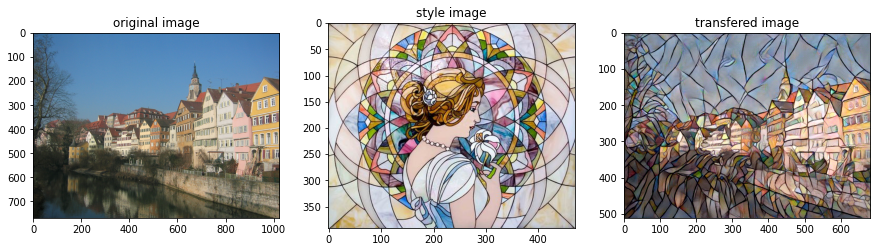

In [ ]:
out_img_hr = post(out_img.data[0].cpu().squeeze())

plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transfered image')
plt.imshow(out_img_hr)
plt.show()



# Perceptual Losses for Style Transfer with Pytorch


**Main idea**

Previous method produces high-quality results, but is computationally expensive since each step of the optimization problem requires a forward and backward pass through the pretrained network. To overcome this computational burden, we train a feed-forward network to quickly approximate solutions to their optimization problem.
<img src="http://drive.google.com/uc?export=view&id=1GFM9l-63SsOFYHP-g2WNN2T6zNDdD09Z" alt="no_image" style="width: 900px;"/>

$\mathcal{L}_{total} = \alpha\sum_{}{\mathcal{l}_{content}} + \beta\sum_{}{\mathcal{l}_{style}} + \gamma\mathcal{l}_{TV}$

- $\mathcal{l}_{content}^{\phi,j} = ||\phi_j(\hat{y}) - \phi_j(y)||^2_2$, $\phi$ represents vgg feature

- $\mathcal{l}_{style}^{\phi,j} = ||G^{\phi}_{j}(\hat{y}) - G^{\phi}_{j}(y)||^2_F$, $G$ represents gram matrix.

- $\mathcal{l}_{TV}(y) = \sum_{i,j}{|y_{i+1,j}-y_{i,j}|+|y_{i,j+1}-y_{i,j}|}$



**Data loader**

In [ ]:
data_root = '../dataset/lab10/train'
image_size = 224
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_root, transform)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### 1.1 Write code (Image Transform Net) [3 points]

<img src="http://drive.google.com/uc?export=view&id=1OQzOwfRgpncvvBCwUCJbShYQGBElUqjW" alt="no_image" style="width: 400px;"/>

##### Residual block (channel, x)
- Conv 1: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv 2: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Residual Connection

#### ImageTransformNet
- Conv $9\times9$  (in: 3, out: 32, padding: 4) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 32, out: 64, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 64, out:128, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- 5 Residual block(channel: 128)
- $2\times$ Nearest Upsample
- Conv $3\times3$  (in: 128, out:64, padding: 1) with reflection padding
- Instance Norm
- Relu
- **$2\times$ Nearest Upsample**
- Conv $3\times3$  (in: 64, out:32, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv $9\times9$  (in: 32, out:3, padding: 4) with reflection padding



In [ ]:
class Conv_Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, reflection_padding='reflect'):
        super(Conv_Block, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, padding_mode=reflection_padding),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.conv_block(x)
        
class Identity_mapping(nn.Module):
  def __init__(self):
    super(Identity_mapping, self).__init__()
    self.block = nn.Sequential(
        Conv_Block(128, 128, 3, 1, 1),
        nn.Conv2d(128, 128, 3, 1, 1),
        nn.InstanceNorm2d(128)
    )

  def forward(self, x):
    f = self.block(x)
    out = f + x
    
    return out

class ImageTransformNet(torch.nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        self.front = nn.Sequential(
            Conv_Block(3, 32, 9, 1, 4),
            Conv_Block(32, 64, 3, 2, 1),
            Conv_Block(64, 128, 3, 2, 1)
        )
        self.residual = nn.Sequential(
            Identity_mapping(),
            Identity_mapping(),
            Identity_mapping(),
            Identity_mapping(),
            Identity_mapping(),
        )
        self.back = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            Conv_Block(128, 64, 3, 1, 1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Conv_Block(64, 32, 3, 1, 1),
            nn.Conv2d(32, 3, 9, 1, 4)  
        )
        

    def forward(self, X):
        X = self.front(X)
        X = self.residual(X)
        out = self.back(X)
        
        return out

In [ ]:
transformer = ImageTransformNet().cuda()

### 1.2 Find style and content representation layers in loss net [1 points]

In [ ]:
style_layer_name = {
    '3' : "c1-2",
    '8' : "c2-2",
    '15': "c3-3",
    '24': "c4-3"
}

content_layer_name = {
    '8' : "c2-2",
}

In [ ]:
style = transform(style_img).cuda().unsqueeze(0)
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]

**Hyper parameters**

In [ ]:
# You may adjust hyper paramters 
alpha = 1e0
beta = 1e4
gamma = 1e-5

LR = 1e-3
steps = 2000
optimizer = optim.Adam(transformer.parameters(), LR)

### 1.3 Train the image transformNet [4 points]

- Print total loss, content loss, style loss and total variation loss for every 50 iterations
- Style loss should contain all of the layers listed above
- Use alpha, beta, gamma as coefficient

In [ ]:
transformer.train()
n_iter = 0
total_running_loss = 0.0
style_running_loss = 0.0
content_running_loss = 0.0
tv_running_loss = 0.0

class Found(Exception): pass
try:
    while True:
        for x, _ in train_loader:
            optimizer.zero_grad()
            criterion = nn.MSELoss()
            
            x = x.cuda()
            out_img = transformer(x)
            
            # compute content loss
            content_layers = [f for f in loss_net(out_img, content_layer_name).values()]
            content_gt = [A.detach() for A in loss_net(x, content_layer_name).values()] # y_c = x

            content_loss = alpha * criterion(content_layers[0], content_gt[0])
            
            # compute style loss
            style_layers = [gram_matrix(f) for f in loss_net(out_img, style_layer_name).values()]

            style_loss = 0
            for i in range(len(style_layers)):
                style_loss += criterion(style_layers[i], style_gt[i])
            style_loss *= beta
            
            # compute l_TV
            first_term = torch.sum(torch.abs(out_img[:, :, :, 1:] - out_img[:, :, :, :-1]))
            second_term = torch.sum(torch.abs(out_img[:, :, 1:, :] - out_img[:, :, :-1, :]))
            tv_loss = (first_term + second_term) * gamma

            total_loss = content_loss + style_loss + tv_loss
            total_loss.backward()
            n_iter += 1
            # print loss
            if n_iter % show_iter ==(show_iter - 1):
                print(f"Iteration: {n_iter+1}, total loss: {total_loss}, content loss: {content_loss}, style loss: {style_loss}, tv loss: {tv_loss}")
            if n_iter >= steps:
                raise Found
                
            optimizer.step()

except Found:
    pass
    

Iteration: 50, total loss: 24.283788681030273, content loss: 12.494918823242188, style loss: 9.16961669921875, tv loss: 2.6192526817321777
Iteration: 100, total loss: 19.737478256225586, content loss: 10.608931541442871, style loss: 6.556153297424316, tv loss: 2.572392702102661
Iteration: 150, total loss: 18.41533660888672, content loss: 10.183963775634766, style loss: 5.589473247528076, tv loss: 2.6418981552124023
Iteration: 200, total loss: 18.659526824951172, content loss: 11.322718620300293, style loss: 4.582685947418213, tv loss: 2.754121780395508
Iteration: 250, total loss: 17.033056259155273, content loss: 9.900754928588867, style loss: 4.302544116973877, tv loss: 2.8297581672668457
Iteration: 300, total loss: 15.78893756866455, content loss: 9.376484870910645, style loss: 3.675851345062256, tv loss: 2.7366015911102295
Iteration: 350, total loss: 15.376172065734863, content loss: 8.862320899963379, style loss: 3.8225443363189697, tv loss: 2.6913068294525146
Iteration: 400, total

### 1.4 Discuss the result [2 points]
- Compare the result of neural style with yours
- Adjust the hyper parameter and analyze each result
- Use transform function before and after inference

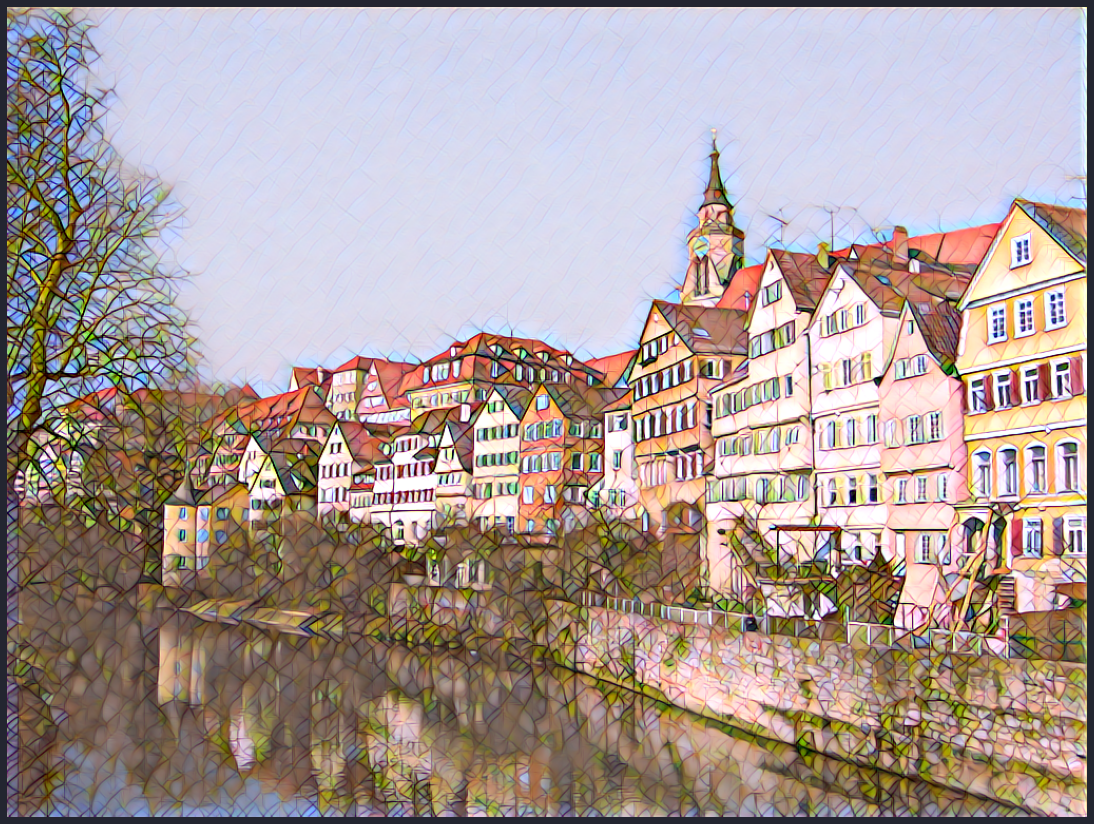

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                         std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

#############
x = test_transform(content_img).cuda().unsqueeze(0)
out_img = transformer(x)
out_img_hr = inverse_transform(out_img.data[0].cpu().squeeze())

fig = plt.figure(facecolor='#232530')
fig.set_size_inches(15,15)
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(out_img_hr)
plt.show()
#############

### *References*
[1] Neural Transfer Pytorch Tutorial (https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)

content image와 style image, 이 두장의 이미지로 style transfer를 통해 많은 이미지를 뽑아낼 수 있다.
content layer를 뒤의 layer로 바꿔봄으로써 여러 object의 edge정보를 약하게 줄 수도 있으며,
여러 parameter(이 프로그램에서 alpha, beta)를 수정함으로써 content 또는 style image에 중점을 어디다 둘 것인지 정함으로써 다양한 이미지를 추출할 수 있다.
사람마다 사진의 좋음에 대한 주관성이 있기 때문에 stlye transfer는 이 부분을 충족시킬 수 있을 것 같다.

![image.png](attachment:d861edeb-fe0f-47c6-b985-18c8bd4512ae.png)

![image.png](attachment:20b63c12-0015-4c32-a1ca-d40b4e1a14b1.png)

udnie.jpg를 style image로 하여 style transfer를 진행해보았다.
예상하지 못한 출력 이미지가 결과로 나와, style transfer에 대해 조금 더 조사를 한 결과
스타일이미지를 gram matrix를 통해 style loss로 구하는 것이, 정확한 정의인가에 대해서 논의 중이었고, hyperparameter에 대해서도 더 깊이 이해할 필요가 있다고 생각하였다.
